In [1]:
import tensorflow as tf
tf.enable_eager_execution()
tfe = tf.contrib.eager

from os import listdir
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import time
from PIL import Image
import numpy as np
import cv2
from IPython import display
from tensorflow.python.keras import models
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization,LeakyReLU,Dropout,Add,concatenate


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



## Step 1 : Read Data

In [2]:
# ! unzip train_8k.zip

In [3]:
# # Read images from folder
# height = 256
# width  = 256

# from os import listdir

# def loadImages(path):
#   """This function will load images from folder
  
#   Arguments:
#     path: the folder path
      
#   Returns:
#     returns a list contains all images
#   """
#   imagesList = listdir(path)
#   loadedImages = []
#   for image in imagesList:
#     if image[::-1][:4] == '.jpg'[::-1]:
#       img = Image.open(path + image)
#       img = img.resize((width, height))
#       loadedImages.append(img)
#   return loadedImages

# path = "./VOC110/"
# source_images = loadImages(path)
# n=len(source_images)

In [4]:
# source_array= np.zeros(shape=(n, width, height, 3), dtype='float32')
# for i in range(n):
#   temp = np.asarray(source_images[i], dtype='float32')/255.
#   source_array[i,:,:,:] = cv2.cvtColor(temp, cv2.COLOR_RGB2LAB)
  
# print(source_array.shape)

In [5]:
# source_array = source_array[:4,:,:,:]
# #source_array = np.expand_dims(source_array,axis=0)

## Step 2: Data Preprocess

The inputs of cGANS should be ranged from -1 to 1. 

In [6]:
# source_l = np.asarray([source[:,:,0] for source in source_array])
# source_ab = np.asarray([source[:,:,1:] for source in source_array])

In [7]:
# source_l = source_l/50 -1
# source_ab /= 110
# source_l = np.expand_dims(source_l,axis=3)

In [8]:
# # re-concat
# source_array = np.concatenate((source_l,source_ab),axis=3)

In [2]:
# Version 2: read data from path_lst 
def loadImages(paths, width, height):
  loadedImages = []
  for p in paths:
    image = p.numpy().decode("utf-8") 
    if image[::-1][:4] == '.jpg'[::-1]:
      img = Image.open(image)
      img = img.resize((width, height))
      loadedImages.append(img)
  return loadedImages

In [3]:
# Version 2: read data from path_lst 
def get_batch_img(paths,width,height):
    img = loadImages(paths,width,height)[0]
    temp = np.asarray(img, dtype='float32')/255.
    if len(temp.shape) == 3:
        imgs_array = cv2.cvtColor(temp, cv2.COLOR_RGB2LAB)
        imgs_array = np.asarray(imgs_array,dtype='float32')
        imgs_l = imgs_array[:,:,0]
        imgs_ab = imgs_array[:,:,1:]
        imgs_l = imgs_l/50 -1
        imgs_ab /= 110
        imgs_l = np.expand_dims(imgs_l,axis=0)
        imgs_ab = np.expand_dims(imgs_ab,axis=0)
        imgs_l = np.expand_dims(imgs_l,axis=3)
        imgs_array = np.concatenate((imgs_l,imgs_ab),axis=3)
        return imgs_array,imgs_l,imgs_ab
    else:
        return np.array([]),None,None

In [4]:
# Version 2: make path_lst to be a tf.dataset
def get_batch_tf_dataset(folder_path,batch_size):
  paths = [folder_path + i for i in listdir(folder_path)]
  buffer_size = len(paths)
  dataset = tf.data.Dataset.from_tensor_slices(paths).shuffle(buffer_size).batch(batch_size).prefetch(1)
  return dataset

In [5]:
folder_path = './train/'
batch_size = 1

In [6]:
# buffer_size = len(source_array)
# batch_size = 1

# dataset = tf.data.Dataset.from_tensor_slices((source_array,source_l)).shuffle(buffer_size).batch(batch_size).prefetch(1)

In [7]:
dataset = get_batch_tf_dataset(folder_path,batch_size)

## Step 3: Build Generator and Discriminator

* Generator: U-Net based architecture + resnet. 
* Discriminatot: PatchGAN. 

In [8]:
class Generator(tf.keras.Model):
  def __init__(self):
    super(Generator, self).__init__()
    
    # encoder 
    self.encoder_conv1 = Conv2D(filters=64, kernel_size=(4,4), strides=2, padding="same")
    self.encoder_leakyrelu2 = LeakyReLU(0.2)
    self.encoder_conv2 = Conv2D(filters=128, kernel_size=(4,4), strides=2, padding="same")
    self.encoder_bn2 = BatchNormalization()
    self.encoder_leakyrelu3 = LeakyReLU(0.2)
    self.encoder_conv3 = Conv2D(filters=256, kernel_size=(4,4), strides=2, padding="same")
    self.encoder_bn3 = BatchNormalization()
    self.encoder_leakyrelu4 = LeakyReLU(0.2)
    self.encoder_conv4 = Conv2D(filters=512, kernel_size=(4,4), strides=2, padding="same")
    self.encoder_bn4 = BatchNormalization()
    self.encoder_leakyrelu5 = LeakyReLU(0.2)
    self.encoder_conv5 = Conv2D(filters=512, kernel_size=(4,4), strides=2, padding="same")
    self.encoder_bn5 = BatchNormalization()
    self.encoder_leakyrelu6 = LeakyReLU(0.2)
    self.encoder_conv6 = Conv2D(filters=512, kernel_size=(4,4), strides=2, padding="same")
    self.encoder_bn6 = BatchNormalization()
    self.encoder_leakyrelu7 = LeakyReLU(0.2)
    self.encoder_conv7 = Conv2D(filters=512, kernel_size=(4,4), strides=2, padding="same")
    self.encoder_bn7 = BatchNormalization()
    self.encoder_leakyrelu8 = LeakyReLU(0.2)
    self.encoder_conv8 = Conv2D(filters=512, kernel_size=(4,4), strides=2, padding="same",activation='relu')
    
    #decoder
    self.decoder_convtrans1 = Conv2DTranspose(filters=512, kernel_size=(4,4), strides=2, padding="same")
    self.decoder_bn1 = BatchNormalization()
    self.decoder_dropout1 = Dropout(0.5)
    self.decoder_add1 = Add()
    self.decoder_convtrans2 = Conv2DTranspose(filters=512, kernel_size=(4,4), strides=2, padding="same")
    self.decoder_bn2 = BatchNormalization()
    self.decoder_dropout2 = Dropout(0.5)
    self.decoder_add2 = Add()
    self.decoder_convtrans3 = Conv2DTranspose(filters=512, kernel_size=(4,4), strides=2, padding="same")
    self.decoder_bn3 = BatchNormalization()
    self.decoder_dropout3 = Dropout(0.5)
    self.decoder_add3 = Add()
    self.decoder_convtrans4 = Conv2DTranspose(filters=512, kernel_size=(4,4), strides=2, padding="same")
    self.decoder_bn4 = BatchNormalization()
    self.decoder_add4 = Add()
    self.decoder_convtrans5 = Conv2DTranspose(filters=256, kernel_size=(4,4), strides=2, padding="same")
    self.decoder_bn5 = BatchNormalization()
    self.decoder_add5 = Add()
    self.decoder_convtrans6 = Conv2DTranspose(filters=128, kernel_size=(4,4), strides=2, padding="same")
    self.decoder_bn6 = BatchNormalization()
    self.decoder_add6 = Add()
    self.decoder_convtrans7 = Conv2DTranspose(filters=64, kernel_size=(4,4), strides=2, padding="same")
    self.decoder_bn7 = BatchNormalization()
    self.decoder_add7 = Add()
    self.decoder_convtrans8 = Conv2DTranspose(filters=3, kernel_size=(4,4), strides=2, padding="same",activation='tanh')
    
  def call(self, x,training=True):
    """
    x: input grayscale images---->[N*H*W*1]
    """
    e1 = self.encoder_conv1(x)
    e2 = self.encoder_leakyrelu2(e1)
    e2 = self.encoder_conv2(e2)
    e2 = self.encoder_bn2(e2,training=training)
    e3 = self.encoder_leakyrelu3(e2)
    e3 = self.encoder_conv3(e3)
    e3 = self.encoder_bn3(e3,training=training)
    e4 = self.encoder_leakyrelu4(e3)
    e4 = self.encoder_conv4(e4)
    e4 = self.encoder_bn4(e4,training=training)
    e5 = self.encoder_leakyrelu5(e4)
    e5 = self.encoder_conv5(e5)
    e5 = self.encoder_bn5(e5,training=training)
    e6 = self.encoder_leakyrelu6(e5)
    e6 = self.encoder_conv6(e6)
    e6 = self.encoder_bn6(e6,training=training)
    e7 = self.encoder_leakyrelu7(e6)
    e7 = self.encoder_conv7(e7)
    e7 = self.encoder_bn7(e7,training=training)
    e8 = self.encoder_leakyrelu8(e7)
    e8 = self.encoder_conv8(e8)
    
    d1 = tf.nn.relu(e8)
    d1 = self.decoder_convtrans1(d1)
    d1 = self.decoder_bn1(d1,training=training)
    d1 = self.decoder_dropout1(d1)
    d1 = self.decoder_add1([d1,e7])
    d2 = tf.nn.relu(d1)
    d2 = self.decoder_convtrans2(d2)
    d2 = self.decoder_bn2(d2,training=training)
    d2 = self.decoder_dropout2(d2)
    d2 = self.decoder_add2([d2,e6])
    d3 = tf.nn.relu(d2)
    d3 = self.decoder_convtrans3(d3)
    d3 = self.decoder_bn3(d3,training=training)
    d3 = self.decoder_dropout3(d3)
    d3 = self.decoder_add3([d3,e5])
    d4 = tf.nn.relu(d3)
    d4 = self.decoder_convtrans4(d4)
    d4 = self.decoder_bn4(d4,training=training)
    d4 = self.decoder_add4([d4,e4])
    d5 = tf.nn.relu(d4)
    d5 = self.decoder_convtrans5(d5)
    d5 = self.decoder_bn5(d5,training=training)
    d5 = self.decoder_add5([d5,e3])
    d6 = tf.nn.relu(d5)
    d6 = self.decoder_convtrans6(d6)
    d6 = self.decoder_bn6(d6,training=training)
    d6 = self.decoder_add6([d6,e2])
    d7 = tf.nn.relu(d6)
    d7 = self.decoder_convtrans7(d7)
    d7 = self.decoder_bn7(d7,training=training)
    d7 = self.decoder_add7([d7,e1])
    d8 =tf.nn.relu(d7)
    d8 = self.decoder_convtrans8(d8)
    
    return d8

In [9]:
# How to get 30*30 output correctly!(perhaps try to padding 1 line manually!)
class Discriminator(tf.keras.Model):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.conv1 = Conv2D(filters=64, kernel_size=(4,4), strides=2)
    self.leakyrelu1 = LeakyReLU(0.2)
    self.conv2 = Conv2D(filters=128, kernel_size=(4,4), strides=2)
    self.bn2 = BatchNormalization()
    self.leakyrelu2 = LeakyReLU(0.2)
    self.conv3 = Conv2D(filters=256, kernel_size=(4,4), strides=2)
    self.bn3 = BatchNormalization()
    self.leakyrelu3 = LeakyReLU(0.2)
    self.conv4 = Conv2D(filters=512, kernel_size=(4,4), strides=1,padding='same')
    self.bn4 = BatchNormalization()
    self.leakyrelu4 = LeakyReLU(0.2)
    self.conv5 = Conv2D(filters=1, kernel_size=(4,4), strides=1, padding='same', activation = 'sigmoid')
  
  def call(self,x,training=True):
    x = self.conv1(x)
    x = self.leakyrelu1(x)
    x = self.conv2(x)
    x = self.bn2(x,training=training)
    x = self.leakyrelu2(x)
    x = self.conv3(x)
    x = self.bn3(x,training=training)
    x = self.leakyrelu3(x)
    x = self.conv4(x)
    x = self.bn4(x,training=training)
    x = self.leakyrelu4(x)
    x = self.conv5(x)
    return x

In [10]:
generator = Generator()
discriminator = Discriminator()

In [12]:
# width = 256
# height = 256
# # read data
# test_image = Image.open('bird.jpg')
# test_image = test_image.resize((width, height))

# # data preprocess
# test_array = np.asarray(test_image, dtype='float32')/255.
# test_array = cv2.cvtColor(test_array,cv2.COLOR_RGB2LAB)
# test_array = np.expand_dims(test_array,axis=0)

# # extract features
# test_l = np.asarray(test_array[:,:,:,0],dtype='float32')
# test_l = test_l/50 -1
# test_l = np.expand_dims(test_l,axis=3)
# test_ab = np.asarray(test_array[:,:,:,1:],dtype='float32')
# test_ab /= 110
# test_array = np.concatenate((test_l,test_ab),axis=3)

# # predict images
# generator(test_l,training=False)
# generator.load_weights('generator_epoch70_weight_100.h5')
# images_concate= tf.concat([test_l,test_array],axis=3)
# discriminator(images_concate,training=False)
# discriminator.load_weights('discriminator_epoch70_weight_100.h5')

Instructions for updating:
Colocations handled automatically by placer.


## Step 4: Compute Loss

In [13]:
def discriminator_loss(reals_predictions,fakes_predictions):
  err_reals = tf.losses.sigmoid_cross_entropy(tf.ones_like(reals_predictions),reals_predictions)
  err_fakes = tf.losses.sigmoid_cross_entropy(tf.zeros_like(fakes_predictions),fakes_predictions)
  return (err_reals + err_fakes)/2

In [14]:
def generator_loss(reals,generator_out,fakes_predictions,weight):
    fool_loss = tf.losses.sigmoid_cross_entropy(tf.ones_like(fakes_predictions),fakes_predictions)
    l1_loss = tf.reduce_mean(tf.abs(reals - generator_out))
    return fool_loss + weight*l1_loss

## Step 5: Train

In [15]:
gen_opt = tf.train.AdamOptimizer(learning_rate=2e-4,beta1=0.5)
disc_opt = tf.train.AdamOptimizer(learning_rate=2e-4,beta1=0.5)
#disc_opt = tf.train.GradientDescentOptimizer(1e-2)

In [16]:
def train_step(real_images,real_l,weight,epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    # Generate fake images
    #if epoch % 5 ==0:
    #  fake_images = generator(real_l, training=True)
    #else:
    fake_images = generator(real_l, training=True)
    real_images = tf.cast(real_images,tf.float32)
    images_concate_fake = tf.concat([real_l,fake_images],axis=3)
    images_concate_real= tf.concat([real_l,real_images],axis=3)
    fake_guesses = discriminator(images_concate_fake,training=True)
    flat_fake_guesses = tf.reshape(fake_guesses,[-1])
    real_guesses = discriminator(images_concate_real,training=True)
    flat_real_guesses = tf.reshape(real_guesses,[-1])
    gen_loss = generator_loss(real_images,fake_images,flat_fake_guesses,weight)
    disc_loss = discriminator_loss(flat_real_guesses,flat_fake_guesses)
  
  #if epoch % 5 == 0:
  gen_grads = gen_tape.gradient(gen_loss, generator.variables)
  gen_opt.apply_gradients(zip(gen_grads, generator.variables))
  disc_grads = disc_tape.gradient(disc_loss, discriminator.variables)
  disc_opt.apply_gradients(zip(disc_grads, discriminator.variables))
  return gen_loss, disc_loss

In [17]:
# # Compile the training step with defun for increased performance.
# # Comment out this line for easier debugging.
# train_step = tf.contrib.eager.defun(train_step)

## Step 6: Display and Show

In [19]:
epochs = 20
weight = 100
height = 256
width = 256

In [20]:
def generate_and_display(real_l):
  display.clear_output(wait=True)
  fakes = generator(real_l, training=False).numpy()
  fakes[:,:,:,0] = (fakes[:,:,:,0]+1)*50
  #fakes[:,:,:,0] = (real_l[:,:,:,0]+1)*50
  fakes[:,:,:,1:] *= 110
  imgs = []
  for i in range(fakes.shape[0]):
    img = cv2.cvtColor(fakes[i,:,:,:],cv2.COLOR_LAB2RGB)
    img = np.clip(img*255.,0,255).astype('uint8')
    imgs.append(img)
  fig = plt.figure(figsize=(20,10))
  for i in range(len(imgs)):
      plt.subplot(5,(len(imgs)//5)+1, i+1)
      plt.imshow(imgs[i])
      plt.axis('off')
  plt.show()  

In [21]:
# for epoch in range(epochs):
#   start = time.time()
#   gen_loss = 0
#   disc_loss = 0
#   for idx,data in enumerate(dataset):
#     gen_loss_cur, disc_loss_cur = train_step(data[0],data[1],weight,epoch)
#     gen_loss += gen_loss_cur
#     disc_loss += disc_loss_cur
#   end = time.time()
  
# #   if epoch % 5 == 0:
# #     generate_and_display(source_l)
#   print ('Epoch {}. Seconds {}'.format(epoch, end - start))
#   print ('Epoch {}. Generator Loss {}'.format(epoch, gen_loss))
#   print ('Epoch {}. Discriminator Loss {}'.format(epoch, disc_loss))

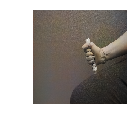

Epoch 19. Seconds 3814.705227136612
Epoch 19. Generator Loss 23091.3359375
Epoch 19. Discriminator Loss 3997.699462890625


In [22]:
# Version 2: OOM version
gen_loss_lst = []
disc_loss_lst = []
for epoch in range(epochs):
  start = time.time()
  gen_loss = 0
  disc_loss = 0
  for idx,data in enumerate(dataset):
    data_array, data_l, data_ab = get_batch_img(data,width,height)
    if len(data_array)!=0:
        gen_loss_cur, disc_loss_cur = train_step(data_array,data_l,weight,epoch)
        gen_loss += gen_loss_cur
        disc_loss += disc_loss_cur
        generate_and_display(data_l)
        gen_loss_lst.append(gen_loss_cur.numpy())
        disc_loss_lst.append(disc_loss_cur.numpy())
  end = time.time()
  
  print ('Epoch {}. Seconds {}'.format(epoch, end - start))
  print ('Epoch {}. Generator Loss {}'.format(epoch, gen_loss))
  print ('Epoch {}. Discriminator Loss {}'.format(epoch, disc_loss))

In [23]:
generator.save_weights('generator_epoch90_weight_100.h5')
discriminator.save_weights('discriminator_epoch90_weight_100.h5')

In [24]:
import pandas
df = pandas.DataFrame(data={"generator": gen_loss_lst, "discriminator": disc_loss_lst})
df.to_csv("loss.csv", sep=',')

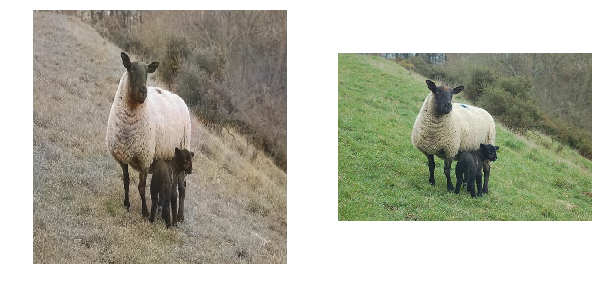

In [25]:
# read data
test_image = Image.open('goat.jpg')
test_image = test_image.resize((width, height))

# data preprocess
test_array = np.asarray(test_image, dtype='float32')/255.
test_array = cv2.cvtColor(test_array,cv2.COLOR_RGB2LAB)
test_array = np.expand_dims(test_array,axis=0)

# extract features
test_l = np.asarray(test_array[:,:,:,0],dtype='float32')
test_l = test_l/50 -1
test_l = np.expand_dims(test_l,axis=3)
test_ab = np.asarray(test_array[:,:,:,1:],dtype='float32')
test_ab /= 110
test_array = np.concatenate((test_l,test_ab),axis=3)

# predict images
test_img_pred = generator(test_l,training=False).numpy()
test_img_pred[:,:,:,0] = (test_img_pred[:,:,:,0]+1)*50
test_img_pred[:,:,:,1:] *= 110
img = cv2.cvtColor(test_img_pred[0,:,:,:],cv2.COLOR_LAB2RGB)
img = np.clip(img*255.,0,255).astype('uint8')

# show the result
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img)
plt.grid(False)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(cv2.imread('goat.jpg',-1), cv2.COLOR_BGR2RGB))
plt.grid(False)
plt.axis('off')
plt.show()

(-0.5, 255.5, 255.5, -0.5)

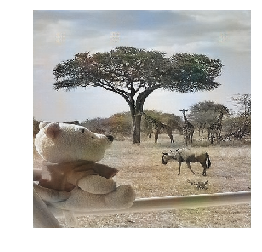

In [43]:
img = generator(data_l, training=False).numpy()
img[:,:,:,0] = (img[:,:,:,0]+1)*50
img[:,:,:,1:] *= 110
img = cv2.cvtColor(img[0,:,:,:],cv2.COLOR_LAB2RGB)
img = np.clip(img*255.,0,255).astype('uint8')
plt.imshow(img)
plt.axis('off')

In [26]:
import os
# Version 1: Write out colorized results only. 
def colorize_image(model,test_path,height,width): 
  
  if os.path.isdir('./results/'):
    !rm -rf results
  !mkdir results
  
  test_imgs = listdir(test_path)
  
  for i in range(len(test_imgs)):
    test_img = Image.open(test_path+test_imgs[i])
    test_img = test_img.resize((width, height))
    test_img = np.asarray(test_img,dtype='float32')/255.
    try:
        test_array = cv2.cvtColor(test_img,cv2.COLOR_RGB2LAB)
    except:
        test_array = cv2.cvtColor(test_img,cv2.COLOR_GRAY2RGB)
        test_img = np.clip(test_array*255.,0,255).astype('uint8')
        test_array = cv2.cvtColor(test_array,cv2.COLOR_RGB2LAB)
    test_gray = cv2.cvtColor(cv2.imread(test_path+test_imgs[i],cv2.IMREAD_GRAYSCALE),cv2.COLOR_GRAY2RGB)
    test_gray = cv2.resize(test_gray,(height,width))
    test_array = np.expand_dims(test_array,axis=0)
    
    test_l = np.asarray(test_array[:,:,:,0],dtype='float32')
    test_l = test_l/50 -1
    test_l = np.expand_dims(test_l,axis=3)
    test_ab = np.asarray(test_array[:,:,:,1:],dtype='float32')
    test_ab /= 110
    test_array = np.concatenate((test_l,test_ab),axis=3)
    
    test_img_pred = generator(test_l,training=False).numpy()
    test_img_pred[:,:,:,0] = (test_img_pred[:,:,:,0]+1)*50
    test_img_pred[:,:,:,1:] *= 110
    img = cv2.cvtColor(test_img_pred[0,:,:,:],cv2.COLOR_LAB2RGB)
    img = np.clip(img*255.,0,255).astype('uint8')

    # show the result
    file_name = './results/img_{0:0=3d}.jpg'.format(i+1)
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.imshow(test_gray)
    plt.title('Grayscale')
    plt.grid(False)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(img)
    plt.title('Prediction')
    plt.grid(False)
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(test_img)
    plt.title('Ground Truth')
    plt.grid(False)
    plt.axis('off')
    plt.savefig(file_name,bbox_inches='tight')
    plt.close()

In [36]:
# import os
# # Version 1: Write out colorized results only. 
# def colorize_image(model,test_path,height,width): 
  
#   if os.path.isdir('./preds/'):
#     !rm -rf preds
#   !mkdir preds
  
#   if os.path.isdir('./trues/'):
#     !rm -rf trues
#   !mkdir trues
  
#   test_imgs = listdir(test_path)
  
#   for i in range(len(test_imgs)):
#     test_img = Image.open(test_path+test_imgs[i])
#     test_img = test_img.resize((width, height))
#     test_img = np.asarray(test_img,dtype='float32')/255.
#     try:
#         test_array = cv2.cvtColor(test_img,cv2.COLOR_RGB2LAB)
#     except:
#         test_array = cv2.cvtColor(test_img,cv2.COLOR_GRAY2RGB)
#         test_img = np.clip(test_array*255.,0,255).astype('uint8')
#         test_array = cv2.cvtColor(test_array,cv2.COLOR_RGB2LAB)
#     test_array = np.expand_dims(test_array,axis=0)
    
#     test_l = np.asarray(test_array[:,:,:,0],dtype='float32')
#     test_l = test_l/50 -1
#     test_l = np.expand_dims(test_l,axis=3)
#     test_ab = np.asarray(test_array[:,:,:,1:],dtype='float32')
#     test_ab /= 110
#     test_array = np.concatenate((test_l,test_ab),axis=3)
    
#     test_img_pred = generator(test_l,training=False).numpy()
#     test_img_pred[:,:,:,0] = (test_img_pred[:,:,:,0]+1)*50
#     test_img_pred[:,:,:,1:] *= 110
#     img = cv2.cvtColor(test_img_pred[0,:,:,:],cv2.COLOR_LAB2RGB)
#     img = np.clip(img*255.,0,255).astype('uint8')

#     # show the result
#     file_name = 'img_{0:0=3d}.jpg'.format(i+1)
#     plt.imshow(img)
#     plt.grid(False)
#     plt.axis('off')
#     plt.savefig('./preds/' + file_name,bbox_inches='tight')
#     plt.close()
#     plt.imshow(test_img)
#     plt.grid(False)
#     plt.axis('off')
#     plt.savefig('./trues/' + file_name,bbox_inches='tight')
#     plt.close()

In [24]:
# !unzip test.zip 

In [27]:
colorize_image(generator,'./test/test/',width,height)

In [28]:
!zip -r ./results.zip ./results
# !zip -r ./preds.zip ./preds
# !zip -r ./trues.zip ./trues

updating: results/ (stored 0%)
updating: results/img_156.jpg (deflated 1%)
updating: results/img_137.jpg (deflated 1%)
updating: results/img_762.jpg (deflated 1%)
updating: results/img_194.jpg (deflated 3%)
updating: results/img_922.jpg (deflated 1%)
updating: results/img_117.jpg (deflated 1%)
updating: results/img_483.jpg (deflated 1%)
updating: results/img_110.jpg (deflated 1%)
updating: results/img_031.jpg (deflated 1%)
updating: results/img_970.jpg (deflated 1%)
updating: results/img_299.jpg (deflated 2%)
updating: results/img_295.jpg (deflated 1%)
updating: results/img_300.jpg (deflated 1%)
updating: results/img_380.jpg (deflated 2%)
updating: results/img_297.jpg (deflated 1%)
updating: results/img_774.jpg (deflated 1%)
updating: results/img_671.jpg (deflated 1%)
updating: results/img_045.jpg (deflated 1%)
updating: results/img_856.jpg (deflated 2%)
updating: results/img_272.jpg (deflated 1%)
updating: results/img_531.jpg (deflated 1%)
updating: results/img_214.jpg (deflated 2%)
u

updating: results/img_766.jpg (deflated 1%)
updating: results/img_019.jpg (deflated 1%)
updating: results/img_350.jpg (deflated 2%)
updating: results/img_759.jpg (deflated 1%)
updating: results/img_510.jpg (deflated 1%)
updating: results/img_583.jpg (deflated 1%)
updating: results/img_910.jpg (deflated 1%)
updating: results/img_441.jpg (deflated 1%)
updating: results/img_337.jpg (deflated 1%)
updating: results/img_609.jpg (deflated 2%)
updating: results/img_858.jpg (deflated 2%)
updating: results/img_735.jpg (deflated 4%)
updating: results/img_707.jpg (deflated 1%)
updating: results/img_231.jpg (deflated 1%)
updating: results/img_348.jpg (deflated 1%)
updating: results/img_245.jpg (deflated 2%)
updating: results/img_205.jpg (deflated 2%)
updating: results/img_330.jpg (deflated 1%)
updating: results/img_470.jpg (deflated 1%)
updating: results/img_384.jpg (deflated 1%)
updating: results/img_129.jpg (deflated 2%)
updating: results/img_712.jpg (deflated 1%)
updating: results/img_523.jpg (d

updating: results/img_679.jpg (deflated 1%)
updating: results/img_698.jpg (deflated 1%)
updating: results/img_351.jpg (deflated 1%)
updating: results/img_225.jpg (deflated 1%)
updating: results/img_934.jpg (deflated 1%)
updating: results/img_509.jpg (deflated 5%)
updating: results/img_259.jpg (deflated 1%)
updating: results/img_339.jpg (deflated 1%)
updating: results/img_892.jpg (deflated 1%)
updating: results/img_017.jpg (deflated 2%)
updating: results/img_118.jpg (deflated 1%)
updating: results/img_465.jpg (deflated 1%)
updating: results/img_487.jpg (deflated 1%)
updating: results/img_681.jpg (deflated 2%)
updating: results/img_291.jpg (deflated 2%)
updating: results/img_614.jpg (deflated 4%)
updating: results/img_883.jpg (deflated 1%)
updating: results/img_018.jpg (deflated 3%)
updating: results/img_262.jpg (deflated 2%)
updating: results/img_633.jpg (deflated 1%)
updating: results/img_254.jpg (deflated 2%)
updating: results/img_647.jpg (deflated 2%)
updating: results/img_041.jpg (d

updating: results/img_789.jpg (deflated 1%)
updating: results/img_767.jpg (deflated 2%)
updating: results/img_944.jpg (deflated 1%)
updating: results/img_812.jpg (deflated 1%)
updating: results/img_429.jpg (deflated 2%)
updating: results/img_486.jpg (deflated 2%)
updating: results/img_558.jpg (deflated 2%)
updating: results/img_924.jpg (deflated 1%)
updating: results/img_280.jpg (deflated 1%)
updating: results/img_308.jpg (deflated 3%)
updating: results/img_428.jpg (deflated 1%)
updating: results/img_548.jpg (deflated 1%)
updating: results/img_674.jpg (deflated 7%)
updating: results/img_624.jpg (deflated 2%)
updating: results/img_540.jpg (deflated 1%)
updating: results/img_654.jpg (deflated 2%)
updating: results/img_795.jpg (deflated 1%)
updating: results/img_863.jpg (deflated 1%)
updating: results/img_408.jpg (deflated 2%)
updating: results/img_426.jpg (deflated 2%)
updating: results/img_230.jpg (deflated 2%)
updating: results/img_033.jpg (deflated 1%)
updating: results/img_270.jpg (d

updating: results/img_182.jpg (deflated 1%)
updating: results/img_040.jpg (deflated 1%)
updating: results/img_159.jpg (deflated 2%)
updating: results/img_284.jpg (deflated 1%)
updating: results/img_055.jpg (deflated 2%)
updating: results/img_878.jpg (deflated 3%)
updating: results/img_364.jpg (deflated 1%)
updating: results/img_989.jpg (deflated 2%)
updating: results/img_941.jpg (deflated 1%)
updating: results/img_563.jpg (deflated 1%)
updating: results/img_043.jpg (deflated 1%)
updating: results/img_407.jpg (deflated 1%)
updating: results/img_146.jpg (deflated 1%)
updating: results/img_936.jpg (deflated 1%)
updating: results/img_518.jpg (deflated 1%)
updating: results/img_891.jpg (deflated 1%)
updating: results/img_163.jpg (deflated 1%)
updating: results/img_819.jpg (deflated 1%)
updating: results/img_587.jpg (deflated 1%)
updating: results/img_189.jpg (deflated 1%)
updating: results/img_872.jpg (deflated 1%)
updating: results/img_471.jpg (deflated 2%)
updating: results/img_817.jpg (d